In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
import warnings


warnings.filterwarnings("ignore")


**Маркетологи запустили массивную рекламную кампанию, в результате в приложение пришло довольно много новых пользователей, вы можете видеть всплеск на графике активной аудитории.**

## Функции

In [2]:
def show_dfs(inp_df):
    print("ads")
    display(inp_df[inp_df.source == "ads"].head())
    display(inp_df[inp_df.source == "ads"].tail())
    print("organic")
    display(inp_df[inp_df.source == "organic"].head())
    display(inp_df[inp_df.source == "organic"].tail())

## Подключение к базе данных

In [3]:
connection = {'host': 'https://karpov_courses_clickhouse_db',
              'database':'simulator_20221220',
              'user':'user_name', 
              'password':'password'
             }

query = '''
select count(distinct user_id) as users,
       toDate(time) as date
from {db}.feed_actions
group by date
'''

df_act = ph.read_clickhouse(query, connection=connection)

## Анализ данных

Нарисуем график количества уникальных пользователей от даты

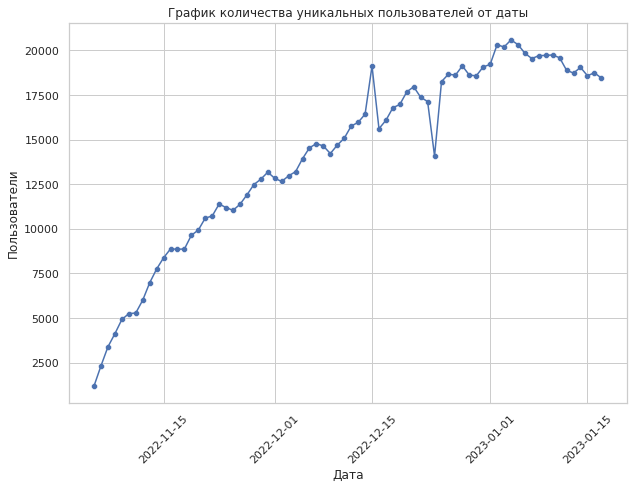

In [4]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={"figure.figsize": (10, 7)}
)

ax = sns.lineplot(data=df_act, x="date", y="users")
ax = sns.scatterplot(data=df_act, x="date", y="users")
ax.set(title="График количества уникальных пользователей от даты")
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='Дата', ylabel='Пользователи')
plt.show()

Найдем дату аномально высокого количества уникальных пользователей

In [5]:
df_act[df_act.date == "2022-12-15"]

,users,date
40,19123,2022-12-15


Получение данных для Retention

In [6]:
in_date = "2022-12-15"
db = "{db}"

query = f'''
SELECT ROUND(100 * (users / max_users)) AS per_users,
       users,
       date,
       source
FROM (
      SELECT users, 
             date,
             (SELECT MAX(users)
             FROM
             (
             SELECT COUNT(user_id) AS users, 
                    date,
                    'ads' AS source 
             FROM
               (SELECT DISTINCT user_id, 
                       toDate(time) AS date
                FROM {db}.feed_actions
                WHERE source = 'ads') AS table_1
             WHERE user_id  IN (SELECT DISTINCT user_id
                                FROM
                                (SELECT user_id, 
                                        MIN(toDate(time)) as min_date
                                 FROM {db}.feed_actions 
                                 GROUP BY user_id
                                 HAVING min_date = '{in_date}') AS table_2)
             GROUP BY date
             
             UNION ALL
             
             SELECT COUNT(user_id) AS users, 
                    date,
                    'organic' AS source 
             FROM
               (SELECT DISTINCT user_id, 
                       toDate(time) AS date
                FROM {db}.feed_actions
                WHERE source = 'organic') AS table_1
             WHERE user_id  IN (SELECT DISTINCT user_id
                                FROM
                                (SELECT user_id, 
                                        MIN(toDate(time)) AS min_date
                                 FROM {db}.feed_actions 
                                 GROUP BY user_id
                                 HAVING min_date = '{in_date}') AS table_2)
             GROUP BY date
             )) as max_users,
             source 
      FROM 
      (
      SELECT COUNT(user_id) AS users, 
             date,
             'ads' AS source 
      FROM
        (SELECT DISTINCT user_id, 
                toDate(time) AS date
         FROM {db}.feed_actions
         WHERE source = 'ads') AS table_1
      WHERE user_id  IN (SELECT DISTINCT user_id
                         FROM
                         (SELECT user_id, 
                                 MIN(toDate(time)) as min_date
                          FROM {db}.feed_actions 
                          GROUP BY user_id
                          HAVING min_date = '{in_date}') AS table_2)
      GROUP BY date
      
      UNION ALL
      
      SELECT COUNT(user_id) AS users, 
             date,
             'organic' AS source 
      FROM
        (SELECT DISTINCT user_id, 
                toDate(time) AS date
         FROM {db}.feed_actions
         WHERE source = 'organic') AS table_1
      WHERE user_id  IN (SELECT DISTINCT user_id
                         FROM
                         (SELECT user_id, 
                                 MIN(toDate(time)) AS min_date
                          FROM {db}.feed_actions
                          GROUP BY user_id
                          HAVING min_date = '{in_date}') AS table_2)
      GROUP BY date))

'''

df_2022_12_15 = ph.read_clickhouse(query, 
                                   connection=connection)
df_2022_12_12 = ph.read_clickhouse(query.replace("'2022-12-15'", "'2022-12-12'"), 
                                   connection=connection)
df_2022_12_18 = ph.read_clickhouse(query.replace("'2022-12-15'", "'2022-12-18'"), 
                                   connection=connection)

In [7]:
print("2022-12-12")
show_dfs(df_2022_12_12)

2022-12-12
ads


,per_users,users,date,source
0,100.0,1365,2022-12-12,ads
1,45.0,616,2022-12-13,ads
2,40.0,543,2022-12-14,ads
3,39.0,530,2022-12-15,ads
4,37.0,500,2022-12-16,ads


,per_users,users,date,source
32,9.0,126,2023-01-13,ads
33,11.0,144,2023-01-14,ads
34,9.0,121,2023-01-15,ads
35,9.0,123,2023-01-16,ads
36,9.0,128,2023-01-17,ads


organic


,per_users,users,date,source
37,85.0,1155,2022-12-12,organic
38,44.0,604,2022-12-13,organic
39,40.0,548,2022-12-14,organic
40,39.0,528,2022-12-15,organic
41,37.0,501,2022-12-16,organic


,per_users,users,date,source
69,14.0,193,2023-01-13,organic
70,13.0,180,2023-01-14,organic
71,14.0,194,2023-01-15,organic
72,15.0,207,2023-01-16,organic
73,15.0,205,2023-01-17,organic


In [8]:
print("2022-12-15")
show_dfs(df_2022_12_15)

2022-12-15
ads


,per_users,users,date,source
0,100.0,3688,2022-12-15,ads
1,3.0,106,2022-12-16,ads
2,3.0,124,2022-12-17,ads
3,3.0,122,2022-12-18,ads
4,3.0,108,2022-12-19,ads


,per_users,users,date,source
29,1.0,41,2023-01-13,ads
30,1.0,40,2023-01-14,ads
31,1.0,38,2023-01-15,ads
32,1.0,30,2023-01-16,ads
33,1.0,42,2023-01-17,ads


organic


,per_users,users,date,source
34,20.0,756,2022-12-15,organic
35,7.0,256,2022-12-16,organic
36,7.0,260,2022-12-17,organic
37,6.0,232,2022-12-18,organic
38,6.0,228,2022-12-19,organic


,per_users,users,date,source
63,2.0,90,2023-01-13,organic
64,2.0,92,2023-01-14,organic
65,2.0,92,2023-01-15,organic
66,3.0,95,2023-01-16,organic
67,2.0,89,2023-01-17,organic


In [9]:
print("2022-12-18")
show_dfs(df_2022_12_18)

2022-12-18
ads


,per_users,users,date,source
0,92.0,1092,2022-12-18,ads
1,35.0,415,2022-12-19,ads
2,33.0,388,2022-12-20,ads
3,33.0,386,2022-12-21,ads
4,31.0,363,2022-12-22,ads


,per_users,users,date,source
26,8.0,95,2023-01-13,ads
27,8.0,92,2023-01-14,ads
28,8.0,94,2023-01-15,ads
29,8.0,92,2023-01-16,ads
30,8.0,90,2023-01-17,ads


organic


,per_users,users,date,source
31,100.0,1183,2022-12-18,organic
32,42.0,499,2022-12-19,organic
33,42.0,495,2022-12-20,organic
34,40.0,471,2022-12-21,organic
35,39.0,462,2022-12-22,organic


,per_users,users,date,source
57,14.0,160,2023-01-13,organic
58,14.0,165,2023-01-14,organic
59,15.0,179,2023-01-15,organic
60,12.0,144,2023-01-16,organic
61,12.0,141,2023-01-17,organic


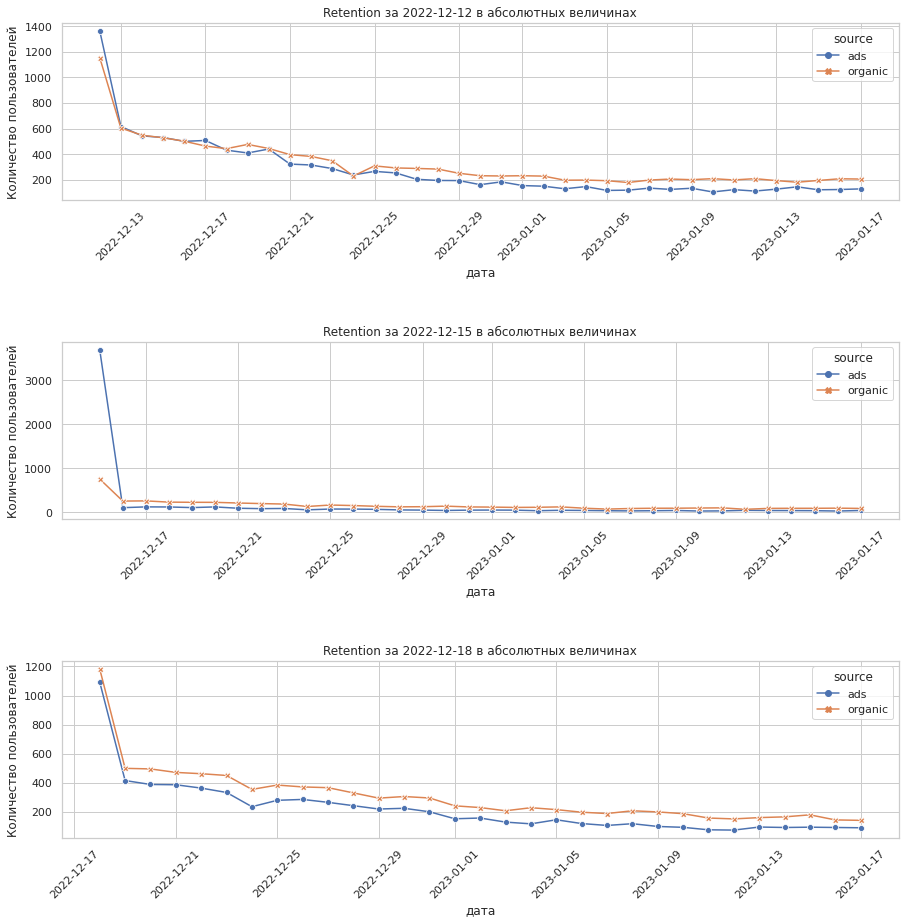

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.8)

ax1 = sns.lineplot(data=df_2022_12_12, 
                   x="date", y="users", style="source",
                   hue="source", markers=True, dashes=False, ax=axs[0])
ax1.tick_params(axis='x', rotation=45)
ax1.set(xlabel='дата', ylabel='Количество пользователей')
ax1.set(title="Retention за 2022-12-12 в абсолютных величинах")

ax2 = sns.lineplot(data=df_2022_12_15, 
                   x="date", y="users", style="source",
                   hue="source", markers=True, dashes=False, ax=axs[1])
ax2.tick_params(axis='x', rotation=45)
ax2.set(xlabel='дата', ylabel='Количество пользователей')
ax2.set(title="Retention за 2022-12-15 в абсолютных величинах")

ax3 = sns.lineplot(data=df_2022_12_18, 
                   x="date", y="users", style="source",
                   hue="source", markers=True, dashes=False, ax=axs[2])
ax3.tick_params(axis='x', rotation=45)
ax3.set(xlabel='дата', ylabel='Количество пользователей')
ax3.set(title="Retention за 2022-12-18 в абсолютных величинах")

plt.show()

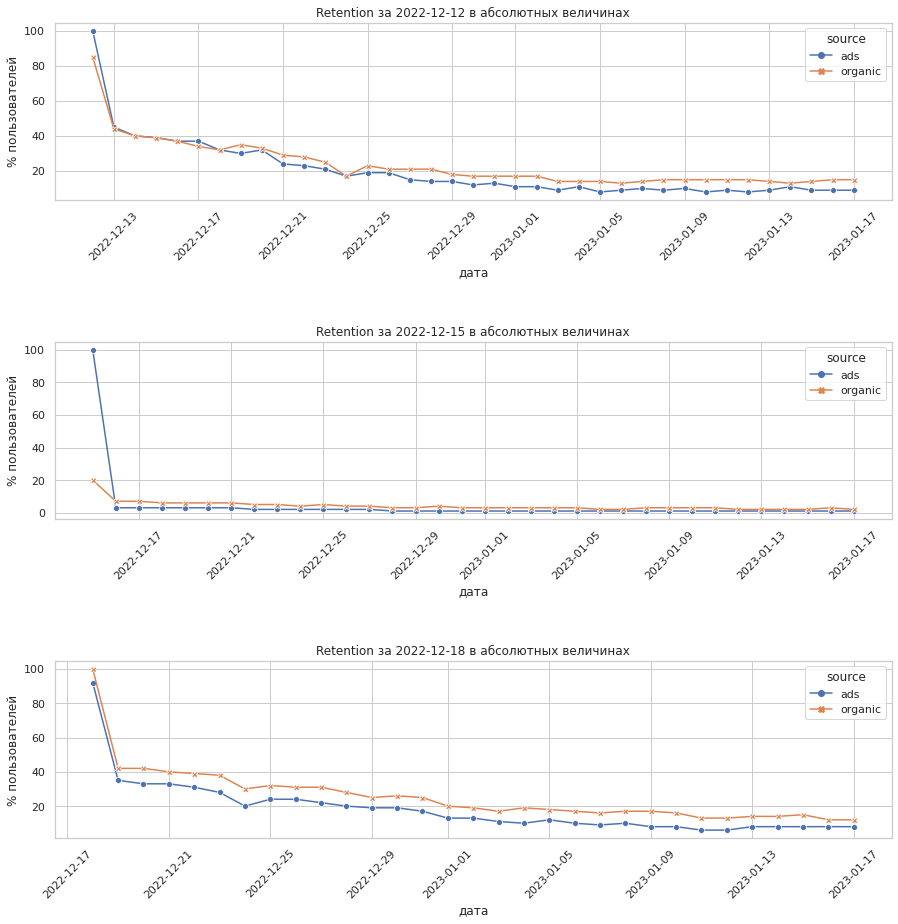

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
plt.subplots_adjust(hspace=0.8)

ax1 = sns.lineplot(data=df_2022_12_12, 
                   x="date", y="per_users", style="source",
                   hue="source", markers=True, dashes=False, ax=axs[0])
ax1.tick_params(axis='x', rotation=45)
ax1.set(xlabel='дата', ylabel='% пользователей')
ax1.set(title="Retention за 2022-12-12 в абсолютных величинах")

ax2 = sns.lineplot(data=df_2022_12_15, 
                   x="date", y="per_users", style="source",
                   hue="source", markers=True, dashes=False, ax=axs[1])
ax2.tick_params(axis='x', rotation=45)
ax2.set(xlabel='дата', ylabel='% пользователей')
ax2.set(title="Retention за 2022-12-15 в абсолютных величинах")

ax3 = sns.lineplot(data=df_2022_12_18, 
                   x="date", y="per_users", style="source",
                   hue="source", markers=True, dashes=False, ax=axs[2])
ax3.tick_params(axis='x', rotation=45)
ax3.set(xlabel='дата', ylabel='% пользователей')
ax3.set(title="Retention за 2022-12-18 в абсолютных величинах")

plt.show()

**Вывод:**
<br/>
<br/>
По анализу выше видно, что по ads на 2022-12-15 мы привлекли очень много пользователей, что привлекло к положительному всплеску уникальных пользователей на первом графике, но на графиках с Retention видно, что это ни к чему не привело, то есть больше клиентов пользоваться приложением не стало, если сравнить это с датами 2022-12-12 и 2022-12-18, на графиках с этими датами хорошо видно, что даже в эти даты не так быстро в абсолютном и процентном значении падало количество пользователей. То есть маркетинговая рекламная компания не принесла приложению в дальнейшем больше аудитории и скорее привела к негативным результатам.